<a href="https://colab.research.google.com/github/subh-775/Academicia/blob/main/augmentation_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install datasets==2.12.0
# !pip install huggingface-hub==0.14.1
# !pip install pillow==9.5.0
# !pip install torchvision==0.15.1

In [ ]:
!pip install datasets

In [2]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
dataset = load_dataset("Subh775/Rice-Disease-Classification-Dataset")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.08k [00:00<?, ?B/s]

rename.zip:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4078 [00:00<?, ? examples/s]

In [3]:
import os
from datasets import DatasetDict
from PIL import Image
import torch
import random
from huggingface_hub import login
login()

In [ ]:
# !pip install pillow==9.5.0 --upgrade
# !pip install --upgrade pillow

In [4]:
import torchvision.transforms as T

In [5]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4078
    })
})


<ipython-input-6-2fa620b4e518>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(label_counts_named.keys()), y=list(label_counts_named.values()), palette="viridis")


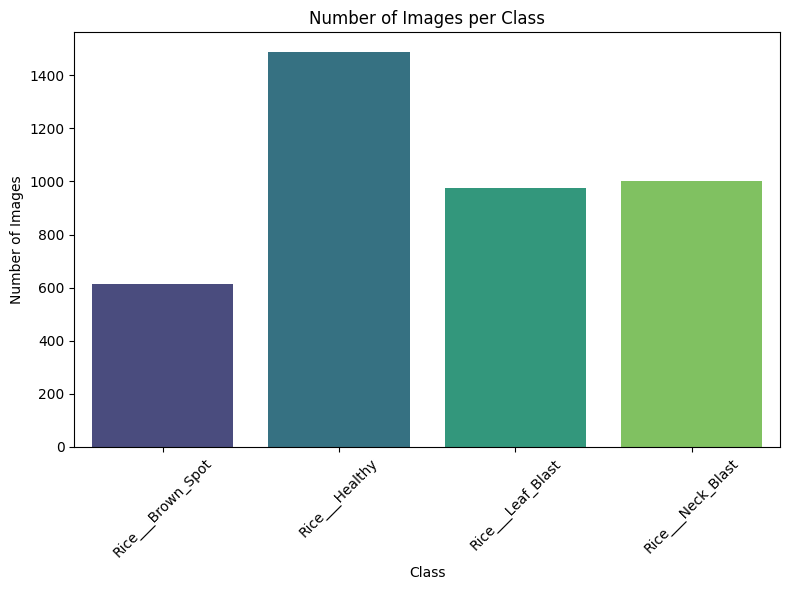

In [6]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
dataset = load_dataset("Subh775/Rice-Disease-Classification-Dataset", split="train")

# Extract labels
labels = [example['label'] for example in dataset]

# Count occurrences of each label
from collections import Counter
label_counts = Counter(labels)

# Map label indices to class names
label_names = dataset.features['label'].names
label_counts_named = {label_names[k]: v for k, v in label_counts.items()}

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=list(label_counts_named.keys()), y=list(label_counts_named.values()), palette="viridis")
plt.title("Number of Images per Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
#data augmentation
augment_transform = T.Compose([
    T.RandomResizedCrop(size=256, scale=(0.8, 1.0)),  # Crop portion of image
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.RandomRotation(degrees=15),
    T.ToTensor()
])

In [10]:
# 1. Create an output folder
base_dir = "augmented_dataset"
os.makedirs(base_dir, exist_ok=True)

# 2. Get label names for easy mapping
label_names = dataset.features["label"].names  # e.g. ["Rice__Brown_Spot", "Rice__Healthy", ...]

# 3. Group by class
grouped_data = {}
for sample in dataset:
    img = sample["image"]
    label_id = sample["label"]
    label_name = label_names[label_id]

    if label_name not in grouped_data:
        grouped_data[label_name] = []
    grouped_data[label_name].append(img)

# 4. For each class, augment to reach 1,000 images
desired_count = 1492

for label_name, images in grouped_data.items():
    class_dir = os.path.join(base_dir, label_name)
    os.makedirs(class_dir, exist_ok=True)

    print(f"Processing class: {label_name} | Original count: {len(images)}")

    # Save the original images first
    for idx, pil_img in enumerate(images):
        # Convert to RGB just in case
        pil_img = pil_img.convert("RGB")
        pil_img.save(os.path.join(class_dir, f"{label_name}_{idx:04d}.jpg"))

    # If we have fewer than desired_count, augment
    current_count = len(images)
    if current_count < desired_count:
        needed = desired_count - current_count
        print(f"  -> Augmenting {needed} new images...")

        for extra_idx in range(needed):
            # Pick a random image from the original set
            pil_img = random.choice(images).convert("RGB")

            # Apply random transformations
            aug_img_tensor = augment_transform(pil_img)

            # Convert the tensor back to PIL before saving
            aug_img = T.ToPILImage()(aug_img_tensor)

            # Save the augmented image
            save_path = os.path.join(class_dir, f"{label_name}_aug_{extra_idx:04d}.jpg")
            aug_img.save(save_path)
    else:
        print("  -> Already has 1000 or more images; skipping augmentation.")

print("✅ Augmentation complete!")  #estimated time: 11m 30s

Processing class: Rice___Brown_Spot | Original count: 613
  -> Augmenting 879 new images...
Processing class: Rice___Healthy | Original count: 1488
  -> Augmenting 4 new images...
Processing class: Rice___Leaf_Blast | Original count: 977
  -> Augmenting 515 new images...
Processing class: Rice___Neck_Blast | Original count: 1000
  -> Augmenting 492 new images...
✅ Augmentation complete!


In [11]:
# Now, create a new dataset from this folder
aug_ds = load_dataset("imagefolder", data_dir=base_dir)
print(aug_ds)

Resolving data files:   0%|          | 0/5968 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5968
    })
})


In [12]:
# Convert to DatasetDict if needed
aug_ds = DatasetDict({"train": aug_ds["train"]})

# You can push to your own user namespace (replace "YourUserName/..." as needed)
aug_ds.push_to_hub("Subh775/Rice-Disease-Augmented")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/5968 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/60 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Subh775/Rice-Disease-Augmented/commit/f2b903f4bb534632b885cfa1f3a8caccfa2ff4fd', commit_message='Upload dataset', commit_description='', oid='f2b903f4bb534632b885cfa1f3a8caccfa2ff4fd', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Subh775/Rice-Disease-Augmented', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Subh775/Rice-Disease-Augmented'), pr_revision=None, pr_num=None)